# Лекция 1: Въведение в ML за език

**Продължителност:** 60-75 минути  
**Следваща лекция:** Невронни мрежи за NLP

## Цели на лекцията

Днес ще изградим два модела от нулата:
- **Текстов класификатор** за spam детекция
- **Езиков модел** за предсказване на следваща дума

Ще видим практически как работи машинното самообучение.

---
## 1. Мотивация

**Успехи на ML за език:**
- ChatGPT, Claude → разговорни асистенти
- Google Translate → превод
- Sentiment analysis → анализ на отзиви

**Какво ще научим:**
Как моделите се учат от текст данни.

---
## 2. Основни библиотеки

In [1]:
import numpy as np
print(f"NumPy версия: {np.__version__}")

NumPy версия: 2.3.4


In [2]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

In [3]:
from collections import Counter
print(Counter(['cat', 'dog', 'cat', 'bird']).most_common(2))

[('cat', 2), ('dog', 1)]


In [4]:
from sklearn.datasets import fetch_20newsgroups
print("Scikit-learn зареден")

Scikit-learn зареден


---
## 3. Какво е ML?

**Проблем:** Дадени са примери (текст, етикет)

**Цел:** Научи модел да предсказва етикета за нов текст

**Пример:**
- "Безплатно!!! Спечели сега!" → spam
- "Здравей, видим се утре?" → not spam

In [5]:
# Примерни данни
texts = ["Безплатно!!!", "Здравей приятелю"]
labels = ["spam", "not spam"]

**Train/Test split:** Учим на обучаващи данни, оценяваме на тестови данни

---
## 4. Текстова класификация (Hands-on)

### Зареждане на данни

In [6]:
data = fetch_20newsgroups(subset='all', categories=['alt.atheism', 'soc.religion.christian'], remove=('headers', 'footers'))
print(f"Документи: {len(data.data)}, Категории: {len(data.target_names)}")

Документи: 1796, Категории: 2


In [7]:
print(data.data[0][:200])
print(f"\nКатегория: {data.target_names[data.target[0]]}")

In article <May.9.05.41.46.1993.27571@athos.rutgers.edu> erh0362@tesla.njit.edu  
writes:
> 
>     Could anyone enlighten me on how the Mormon church views 
> children born out of wedlock?  In particu

Категория: soc.religion.christian


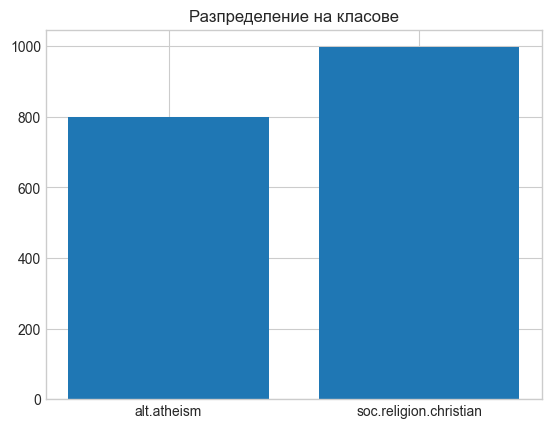

In [8]:
unique, counts = np.unique(data.target, return_counts=True)
plt.bar(data.target_names, counts); plt.title('Разпределение на класове'); plt.show()

### Текст → Числа (Vectorization)

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
X = CountVectorizer(max_features=1000).fit_transform(data.data)

In [10]:
print(f"Размерност: {X.shape}")
print(f"Разредена матрица: {X.nnz / (X.shape[0] * X.shape[1]) * 100:.1f}% ненулеви")

Размерност: (1796, 1000)
Разредена матрица: 10.1% ненулеви


Всеки документ е вектор от 1000 числа (брой думи)

### Обучение на модел

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, data.target, test_size=0.2, random_state=42)

In [12]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=500).fit(X_train, y_train)

In [13]:
from sklearn.metrics import accuracy_score
print(f"Точност на обучаващи данни: {accuracy_score(y_train, model.predict(X_train)):.3f}")
print(f"Точност на тестови данни:  {accuracy_score(y_test, model.predict(X_test)):.3f}")

Точност на обучаващи данни: 0.997
Точност на тестови данни:  0.914


### Какво научи моделът?

In [14]:
y_pred = model.predict(X_test)
print(f"Грешки: {(y_test != y_pred).sum()} от {len(y_test)}")

Грешки: 31 от 360


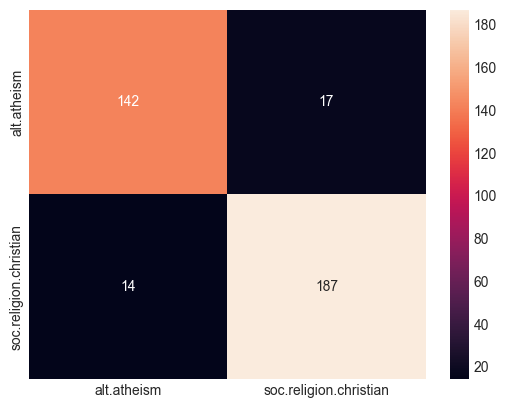

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', xticklabels=data.target_names, yticklabels=data.target_names); plt.show()

### Демонстрация: Пренагаждане

In [16]:
vocab_sizes = [100, 500, 1000, 5000]
train_scores, test_scores = [], []

In [17]:
for v in vocab_sizes:
    X_v = CountVectorizer(max_features=v).fit_transform(data.data)
    X_tr, X_te, y_tr, y_te = train_test_split(X_v, data.target, test_size=0.2, random_state=42)
    m = LogisticRegression(max_iter=500).fit(X_tr, y_tr)
    train_scores.append(m.score(X_tr, y_tr))
    test_scores.append(m.score(X_te, y_te))

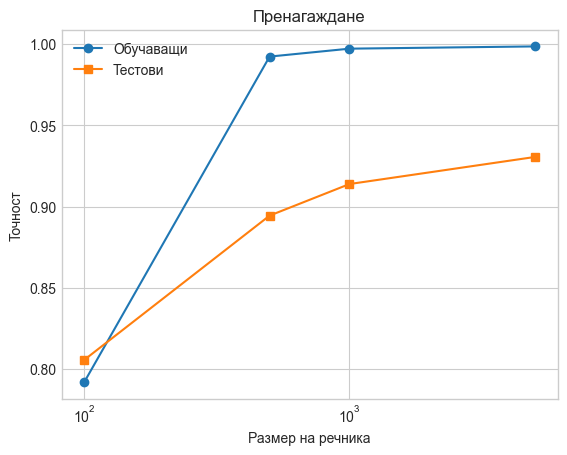

In [18]:
plt.plot(vocab_sizes, train_scores, 'o-', label='Обучаващи')
plt.plot(vocab_sizes, test_scores, 's-', label='Тестови')
plt.xscale('log'); plt.xlabel('Размер на речника'); plt.ylabel('Точност'); plt.legend(); plt.title('Пренагаждане'); plt.show()

С увеличаване на complexity (vocab size), точността на обучаващи данни расте, но точността на тестови данни спира да се подобрява → **пренагаждане**

### Метрики

In [19]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=data.target_names))

                        precision    recall  f1-score   support

           alt.atheism       0.91      0.89      0.90       159
soc.religion.christian       0.92      0.93      0.92       201

              accuracy                           0.91       360
             macro avg       0.91      0.91      0.91       360
          weighted avg       0.91      0.91      0.91       360



**Precision:** От предсказаните като spam, колко са истински spam?

**Recall:** От всички spam, колко открихме?

---
## 5. Езиков модел (Hands-on)

### Какво е езиков модел?

Предсказва следваща дума: **P(word | context)**

Пример: "I love ___" → висока P(this), ниска P(banana)

### Малък корпус

In [20]:
corpus = ["the cat sat", "the dog sat", "the cat ate", "the dog ate", "a cat sat"]
print(corpus)

['the cat sat', 'the dog sat', 'the cat ate', 'the dog ate', 'a cat sat']


### Броене на bigrams

In [21]:
bigrams = []
for sent in corpus:
    words = sent.split()
    bigrams.extend(zip(words[:-1], words[1:]))

In [22]:
bigram_counts = Counter(bigrams)
print(bigram_counts.most_common(5))

[(('the', 'cat'), 2), (('cat', 'sat'), 2), (('the', 'dog'), 2), (('dog', 'sat'), 1), (('cat', 'ate'), 1)]


### Вероятности

In [23]:
word_counts = Counter([w for sent in corpus for w in sent.split()])
print(f"Броене на думи: {word_counts.most_common(3)}")

Броене на думи: [('the', 4), ('cat', 3), ('sat', 3)]


**Формула:** P(w₂ | w₁) = count(w₁, w₂) / count(w₁)

In [24]:
context = 'the'
for next_word in ['cat', 'dog', 'sat']:
    prob = bigram_counts[(context, next_word)] / word_counts[context]
    print(f"P({next_word} | {context}) = {prob:.2f}")

P(cat | the) = 0.50
P(dog | the) = 0.50
P(sat | the) = 0.00


### Визуализация

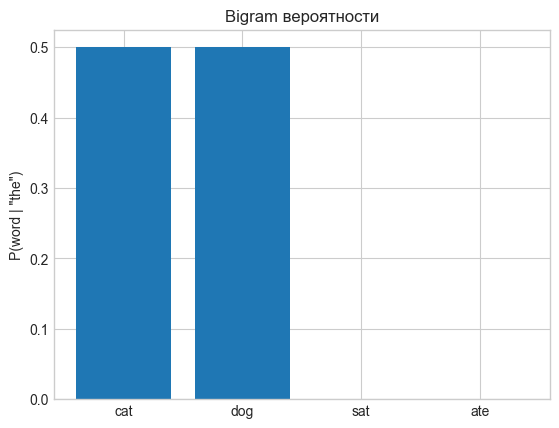

In [25]:
words = ['cat', 'dog', 'sat', 'ate']
probs = [bigram_counts[('the', w)] / word_counts['the'] for w in words]
plt.bar(words, probs); plt.ylabel('P(word | "the")'); plt.title('Bigram вероятности'); plt.show()

### Генериране на текст

In [26]:
current = 'the'
sentence = [current]
for _ in range(5):
    candidates = [w for (w1, w) in bigram_counts if w1 == current]
    if not candidates: break
    current = np.random.choice(candidates)
    sentence.append(current)

In [27]:
print('Генерирано изречение:', ' '.join(sentence))

Генерирано изречение: the cat ate


Често безсмислено → ограничен контекст!

### Перплексия: Оценка на модела

**Перплексия:** Колко "изненадан" е моделът?

$$PP = P(w_1,...,w_n)^{-1/n}$$

По-ниска перплексия = по-добър модел

In [28]:
test_sent = "the cat ate"
words_test = test_sent.split()
prob = 1.0
for w1, w2 in zip(words_test[:-1], words_test[1:]):
    prob *= bigram_counts[(w1, w2)] / word_counts[w1] if word_counts[w1] > 0 else 0.001

In [29]:
perplexity = prob ** (-1/len(words_test))
print(f"Перплексия(\"{test_sent}\") = {perplexity:.2f}")

Перплексия("the cat ate") = 1.82


### Ограничения на n-gram модели

**Проблем 1: Sparsity**

In [30]:
vocab = set(word_counts.keys())
print(f"Речник: {len(vocab)} думи")
print(f"Възможни bigrams: {len(vocab)**2}")
print(f"Наблюдавани bigrams: {len(bigram_counts)}")
print(f"Sparsity: {(1 - len(bigram_counts)/len(vocab)**2)*100:.1f}%")

Речник: 6 думи
Възможни bigrams: 36
Наблюдавани bigrams: 7
Sparsity: 80.6%


**Проблем 2: Липса на генерализация**

In [31]:
print(f"P(sat | cat) = {bigram_counts[('cat', 'sat')] / word_counts['cat']:.2f}")
print(f"P(sat | dog) = {bigram_counts[('dog', 'sat')] / word_counts['dog']:.2f}")
print(f"P(sat | horse) = {bigram_counts[('horse', 'sat')] / word_counts.get('horse', 1):.2f}  (never seen)")
print("\nМоделът не знае, че 'cat', 'dog', 'horse' са сходни!")

P(sat | cat) = 0.67
P(sat | dog) = 0.50
P(sat | horse) = 0.00  (never seen)

Моделът не знае, че 'cat', 'dog', 'horse' са сходни!


**Проблем 3: Къс контекст**

Bigram вижда само 1 дума назад → не може да улови дълъг контекст

**Мост към следваща лекция:**

Невронните мрежи решават тези проблеми:
- Word embeddings → сходни думи са близо в пространството
- По-дълъг контекст
- Генерализация

---
## 6. Обобщение

**Ключови изводи:**

1. ML се учи от примери (текст, етикет)
2. Текст → числа чрез vectorization
3. Train/test split за оценка на генерализация
4. Пренагаждане = висока точност на обучаващи, ниска точност на тестови данни
5. N-gram модели са прости, но имат ограничения

**Следваща лекция:** Невронни мрежи и word embeddings

---
## Упражнения

**1. Модифицирай класификатора**
- Смени от 1-grams на 2-grams
- Сравни точността

**2. Разшири езиковия модел**
- Направи trigram модел
- Сравни перплексията с bigram

**3. Error analysis**
- Намери 5 грешно класифицирани примера
- Защо моделът сгреши?

---
**Край на Лекция 1**